In [429]:
%cd '/home/sisyphe/sol-test/donnees'

/home/sisyphe/sol-test/donnees


In [430]:
import numpy as np
import matplotlib.pyplot as plt
import PIL
import os
from PIL import Image
import tifffile
from tifffile import imsave, imread
import nibabel as nib
import random
from skimage.transform import rotate
from skimage import data
from skimage.transform import rescale
import sklearn
import sklearn.feature_extraction
from keras.models import Model, load_model
import random 
import skimage
import scipy
from scipy import ndimage, misc
from skimage import transform
from skimage.transform import rotate, AffineTransform,warp
from skimage.util import random_noise
from skimage.filters import gaussian
from scipy import ndimage
import random
from skimage import img_as_ubyte
import os

In [431]:
def norm(array):
    return ((array - array.min())/(array.max() - array.min()))

In [432]:
def loading_image_or_segmentation(image_path, mode='AXIAL'):
  img = imread(image_path)
  img = np.array(img)
  img = norm(img) # Normalize between 0 and 1

  if(mode=='SAGITTAL'):
    img = np.transpose(img, (2,0,1))
  
  if(mode=='CORONAL'):
    img = np.transpose(img, (1,0,2))
  
  return img

In [433]:
inputs_im = loading_image_or_segmentation('/home/sisyphe/sol-test/MOG/SH_02234-N.tif', mode='SAGITTAL')
labels_im = loading_image_or_segmentation('/home/sisyphe/sol-test/donnees/Sagittal/SH_02234-N_segmentation_sagittale_6_47-75-169-255-386-438.tif', mode='SAGITTAL')

In [434]:
inputs_im=norm(inputs_im)

In [435]:
def searching_indexes_segmented(segmentation): # When you want to detect which slices are annotated
  indexes = []
  for i in range(0, segmentation.shape[0]):
    if(not np.all(segmentation[i]==0)):
      indexes.append(i)
  return indexes

In [436]:
index_im=inputs_im[[47, 75, 169, 255, 386, 438]]
lab_index_im=labels_im[[47, 75, 169, 255, 386, 438]]

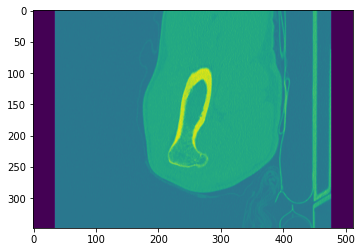

In [437]:
plt.imshow(index_im[4])

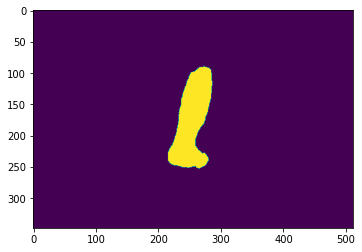

In [438]:
plt.imshow(lab_index_im[4])

In [439]:
def creating_array(image, segmentation, indexes): 
# You can't create an array with coronal and sagittal images as the size is varying
# To create my training arrays I processed one image at a time until I got patches (N,128,128) and then I could concatenate in a big array
  array = np.zeros((len(indexes), segmentation.shape[1], segmentation.shape[2]))
  label_array = np.zeros((len(indexes), segmentation.shape[1], segmentation.shape[2]))

  for i in range(0,len(indexes)):
    array[i] = image[indexes[i]]
    label_array[i] = segmentation[indexes[i]]

  return array, label_array

In [440]:
# Method to augment a single image/label, you have to specify the nb of augmentation for the image (the raw image/label is also saved in the output array)

def data_augmentation_for_single_image(image, label, nb_aug_per_image):
  temp = np.zeros((nb_aug_per_image+1,image.shape[0],image.shape[1]))
  temp_label = np.zeros((nb_aug_per_image+1,image.shape[0],image.shape[1]))
  temp[0] = image
  temp_label[0] = label
  for j in range(1, nb_aug_per_image+1):
    n = random.randint(0,8)
    if(n==0):
      temp[j] = image
      temp_label[j] = label
    if(n==1): #TRANSLATION
      m = random.randint(-100,400)
      c = random.choice(['constant', 'symmetric', 'reflect', 'wrap'])
      transform = AffineTransform(translation=(m,0))
      temp[j] = warp(image,transform, mode=c)
      temp_label[j] = warp(label,transform, mode=c)
    if(n==2): #BLURRING
      temp[j] = ndimage.uniform_filter(image, size=(10, 10))
      temp_label[j] = label
    if(n==3): #UP DOWN FLIP
      temp[j] = np.flipud(image)
      temp_label[j] = np.flipud(label)
    if(n==4): #INCREASING CONTRAST
      temp[j] = image * 2
      temp_label[j] = label
    if(n==5): # ROTATE
      m = random.randint(40,360)
      temp[j] = rotate(image,m)
      temp_label[j] = rotate(label,m)
    if((n==6) or (n==7) or (n==8)): # MULTI TRANSFORMATION
      m = random.randint(40,360)
      temp[j] = rotate(image,m)
      temp[j] = ndimage.uniform_filter(temp[j], size=(10, 10))
      a = random.randint(-100,400)
      b = random.choice(['constant', 'symmetric', 'reflect', 'wrap'])
      transform = AffineTransform(translation=(a,0))
      temp[j] = warp(temp[j],transform, mode=b)

      temp_label[j] = rotate(label,m)
      temp_label[j] = warp(temp_label[j], transform, mode=b)

  return temp, temp_label

In [441]:
# Data augmentation for an array of 2D images/2D label

def data_augmentation(image_array, label_array, nb_aug_per_image):
  augment_images, augment_labels = data_augmentation_for_single_image(image_array[0], label_array[0], nb_aug_per_image)
  for i in range(1,len(image_array)):
    temp, temp_label = data_augmentation_for_single_image(image_array[i], label_array[i], nb_aug_per_image)
    augment_images = np.concatenate((augment_images,temp), axis=0)
    augment_labels = np.concatenate((augment_labels,temp_label), axis=0)
  
  return augment_images, augment_labels

In [442]:
agt_idx, agt_lab=data_augmentation(index_im, lab_index_im, 10)

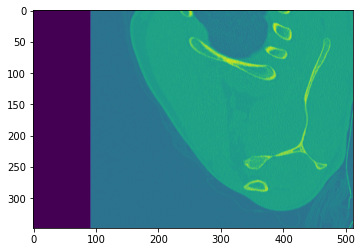

In [443]:
plt.imshow(agt_idx[34])

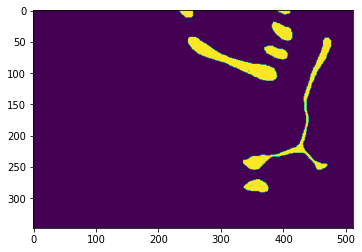

In [444]:
plt.imshow(agt_lab[34])

In [412]:
# Method to create patches from image and label array, you have to specify the patch_size (only one side of a square) and
# the number of patchs you want to create for each image

def creating_patches_from_array(images_array, labels_array, patch_size, max_patches):
  patches = np.zeros((1,patch_size,patch_size))
  label_patches = np.zeros((1,patch_size,patch_size))
  
  for i in range(0,images_array.shape[0]):
    nb = random.randint(0,100)
    patches_2d = sklearn.feature_extraction.image.extract_patches_2d(images_array[i], (patch_size,patch_size), max_patches=max_patches, random_state=nb)
    label_patch_2d = sklearn.feature_extraction.image.extract_patches_2d(labels_array[i], (patch_size,patch_size), max_patches=max_patches, random_state=nb)
    
    patches = np.concatenate((patches, patches_2d), axis=0)
    label_patches = np.concatenate((label_patches, label_patch_2d), axis = 0)

  return patches[1:,:,:], label_patches[1:,:,:]

In [413]:
patch, lab_patch=creating_patches_from_array(agt_idx, agt_lab, 128, 50)

In [414]:
patch.shape

(2750, 128, 128)

In [415]:
def remove_black_inputs(inputs,labels):
  # Taking all indexes that are black labels
  indexes = []
  for i in range(0, inputs.shape[0]):
    if np.all(inputs[i]==0):
      indexes.append(i)
  inputs = np.delete(inputs, indexes, axis = 0)
  labels = np.delete(labels, indexes, axis = 0)
  return inputs, labels

In [416]:
patch, lab_patch=remove_black_inputs(patch, lab_patch)
lab_patch.shape

(2712, 128, 128)

In [417]:
patch.shape

(2712, 128, 128)

In [418]:
def sample_function(): 
  return 0.5

In [419]:
def shuffling_arrays(array):
  random.shuffle(array, sample_function)

In [420]:
shuffling_arrays(patch)
shuffling_arrays(lab_patch)

In [421]:
inputs = np.load('/home/sisyphe/sol-test/patches/patches_sagittal.npy',allow_pickle=True)
labels = np.load('/home/sisyphe/sol-test/patches/label_patches_sagittal.npy',allow_pickle=True)

In [422]:
labels.shape

(58184, 128, 128)

In [423]:
inputs=np.concatenate((inputs, patch))

In [424]:
labels=np.concatenate((labels, lab_patch))

In [425]:
inputs.shape

(60896, 128, 128)

In [426]:
labels.shape

(60896, 128, 128)

In [427]:
np.save('/home/sisyphe/sol-test/patches/patches_sagittal.npy', inputs, allow_pickle=True)

In [428]:
np.save('/home/sisyphe/sol-test/patches/label_patches_sagittal.npy', labels, allow_pickle=True)

Text(0.5, 1.0, 'Predicted')

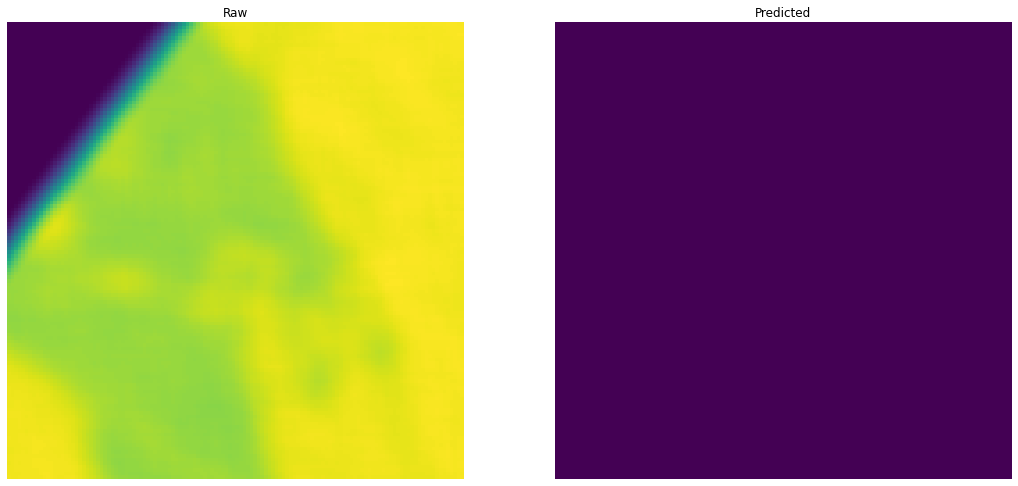

In [379]:
# Utility to check that your labels and inputs are well aligned 
a=random.randint(0, len(inputs))

fig = plt.figure(figsize=(18, 18)) 
  
rows = 1
columns = 2
  
fig.add_subplot(rows, columns, 1) 
  
plt.imshow(inputs[a]) 
plt.axis('off') 
plt.title("Raw") 
  
fig.add_subplot(rows, columns, 2) 
  
plt.imshow(labels[a]) 
plt.axis('off') 
plt.title("Predicted")  

In [22]:
# SAVE YOUR PATCHES/IMAGES OR LABELS